# Proyecto Semestral Minería de datos: Modelo Predictivo de Crimen con Arma de Fuego en EE.UU

* Shu-yi Wong Baxter
* Sebastian Perez Berrios
* Mathias Cáceres Bustamante

#**Librerias**

In [ ]:
import csv
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
from pandas_profiling import ProfileReport
from sklearn import preprocessing 
from sklearn import cluster
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score
from sklearn import metrics
from sklearn import svm
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict

#**Lectura archivos**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/My Drive/Mineria de datos(Modelo)'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
datos=pd.read_csv("/content/drive/My Drive/Mineria de datos(Modelo)/avance 5.5.csv", sep=';')

#**Datos originales**

In [ ]:
datos

incident_id        date  ...  participant_gender       avg_age
0          461105.0  01-01-2013  ...                   2  2.000000e+01
1          460726.0  01-01-2013  ...                   1  2.000000e+01
2          478855.0  01-01-2013  ...                   1  3.075000e+03
3          478925.0  05-01-2013  ...                   2  3.933333e+09
4          478959.0  07-01-2013  ...                   2  3.125000e+03
...             ...         ...  ...                 ...           ...
239563    1083142.0  31-03-2018  ...                   0  2.500000e+01
239564    1083139.0  31-03-2018  ...                   1  2.100000e+01
239565    1083151.0  31-03-2018  ...                   1  2.100000e+01
239566    1082514.0  31-03-2018  ...                   1  4.200000e+01
239567    1081940.0  31-03-2018  ...                   2  6.000000e+01

[239568 rows x 21 columns]

In [ ]:
datos.describe()

incident_id          month  ...  participant_gender       avg_age
count  2.395620e+05  239560.000000  ...       239568.000000  2.375050e+05
mean   5.597832e+05       6.351866  ...            1.384183  6.577790e+07
std    3.107617e+05       3.447823  ...            0.785275  4.501830e+08
min    9.211400e+04       1.000000  ...            0.000000  0.000000e+00
25%    3.089170e+05       3.000000  ...            1.000000  0.000000e+00
50%    5.437510e+05       6.000000  ...            1.000000  2.100000e+01
75%    8.173125e+05       9.000000  ...            2.000000  3.500000e+01
max    3.982186e+07      12.000000  ...            3.000000  9.666667e+09

[8 rows x 15 columns]

In [ ]:
#Para saber cuantos valores nulos hay en el dataset
datos.isnull().sum()

incident_id                      6
date                             8
month                            8
day                              8
state                            7
city_or_county                   6
address                      16497
n_killed                         8
n_injured                        8
congressional_district       11951
gun_stolen                       0
gun_type                         0
incident_characteristics       334
location_description        197482
latitude                      7931
longitude                     7931
n_guns_involved                  0
notes                            0
participant_age_group            0
participant_gender               0
avg_age                       2063
dtype: int64

#**Modificacion de datos**

In [ ]:
#Elimina los nulos de date que son pocos y eso hace que se eliminen los nulos pequeños que
# estan en la misma fila y quedan las columnas que se usaran sin nulos
datos.drop(datos[datos.date.isnull()].index, inplace = True) #Ojo aqui, el inplace true los elimina del dataset original, no hace una copia

In [ ]:
##Datos orginales post pequeña limpieza
datos2 = datos.drop_duplicates()
datos2 = datos.drop(['incident_id','date','address','incident_characteristics','location_description','latitude','longitude','notes','city_or_county','congressional_district'], axis=1) #Eliminar columnas correlacionales a global_sales
datos2.loc[(datos2.avg_age>=0.0)&(datos2.avg_age<18.0) ,'avg_age']=0;
datos2.loc[(datos2.avg_age>=18.0)&(datos2.avg_age<25.0) ,'avg_age']=1;
datos2.loc[(datos2.avg_age>=25.0)&(datos2.avg_age<45.0) ,'avg_age']=2;
datos2.loc[(datos2.avg_age>=45.0)&(datos2.avg_age<70.0) ,'avg_age']=3;
datos2.loc[(datos2.avg_age>=70.0) ,'avg_age']=4;

datos2.loc[(datos2.n_killed==0.0)&(datos2.n_injured==0.0) ,'heridos']=0;
datos2.loc[(datos2.n_killed>=1.0)&(datos2.n_injured==0.0) ,'heridos']=1;
datos2.loc[(datos2.n_killed==0.0)&(datos2.n_injured>=1.0) ,'heridos']=1;
datos2.loc[(datos2.n_killed>=1.0)&(datos2.n_injured>=1.0) ,'heridos']=1;

datos2.loc[(datos2.state==7.0)|(datos2.state==9.0)|(datos2.state==12.0)|(datos2.state==15.0)|(datos2.state==18.0)|(datos2.state==23.0)|(datos2.state==24.0)|(datos2.state==25.0)|(datos2.state==33.0)|(datos2.state==35.0)|(datos2.state==41.0)|(datos2.state==45.0)|(datos2.state==47.0),'state2']=0;
datos2.loc[(datos2.state==3.0)|(datos2.state==8.0)|(datos2.state==16.0)|(datos2.state==20.0)|(datos2.state==26.0)|(datos2.state==27.0)|(datos2.state==31.0)|(datos2.state==32.0)|(datos2.state==39.0)|(datos2.state==44.0)|(datos2.state==50.0),'state2']=1;
datos2.loc[(datos2.state==0.0)|(datos2.state==1.0)|(datos2.state==4.0)|(datos2.state==6.0)|(datos2.state==10.0)|(datos2.state==11.0)|(datos2.state==13.0)|(datos2.state==14.0)|(datos2.state==17.0)|(datos2.state==19.0)|(datos2.state==21.0)|(datos2.state==22.0)|(datos2.state==28.0)|(datos2.state==29.0)|(datos2.state==34.0)|(datos2.state==37.0)|(datos2.state==38.0)|(datos2.state==40.0)|(datos2.state==42.0)|(datos2.state==46.0)|(datos2.state==48.0)|(datos2.state==49.0),'state2']=2;
datos2.loc[(datos2.state==2.0)|(datos2.state==5.0)|(datos2.state==30.0)|(datos2.state==36.0)|(datos2.state==43.0) ,'state2']=3;

datos2 = datos2.drop(['n_killed', 'n_injured', 'state'], axis=1) #Eliminar columnas correlacionales a global_sales

datos2

month  day  gun_stolen  ...  avg_age  heridos  state2
0         1.0  2.0           2  ...      1.0      1.0     1.0
1         1.0  2.0           2  ...      1.0      1.0     2.0
2         1.0  2.0           2  ...      4.0      1.0     3.0
3         1.0  6.0           2  ...      4.0      1.0     0.0
4         1.0  1.0           2  ...      4.0      1.0     3.0
...       ...  ...         ...  ...      ...      ...     ...
239563    3.0  6.0           2  ...      2.0      0.0     2.0
239564    3.0  6.0           2  ...      1.0      1.0     2.0
239565    3.0  6.0           2  ...      1.0      1.0     2.0
239566    3.0  6.0           2  ...      2.0      1.0     2.0
239567    3.0  6.0           2  ...      3.0      1.0     2.0

[239560 rows x 10 columns]

In [ ]:
datos2.isnull().sum()

month                       0
day                         0
gun_stolen                  0
gun_type                    0
n_guns_involved             0
participant_age_group       0
participant_gender          0
avg_age                  2063
heridos                     0
state2                      0
dtype: int64

In [ ]:
datos2.drop(datos2[datos2.avg_age.isnull()].index, inplace = True)

#**Histogramas**

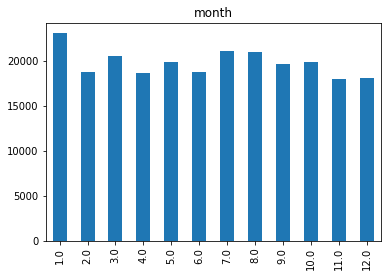

In [ ]:
#Modificacion mes
plot= datos2['month'].value_counts().sort_index(ascending=True).plot(kind='bar',title="month");
plt.show(plot)

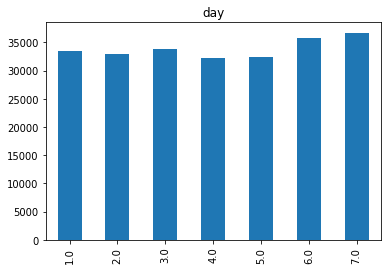

In [ ]:
#Modificacion dia
plot= datos2['day'].value_counts().sort_index(ascending=True).plot(kind='bar',title="day");
plt.show(plot)

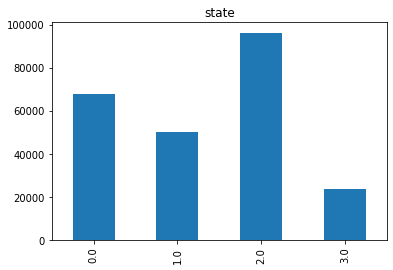

In [ ]:
#Modificacion estado
plot= datos2['state2'].value_counts().sort_index(ascending=True).plot(kind='bar',title="state");
plt.show(plot)

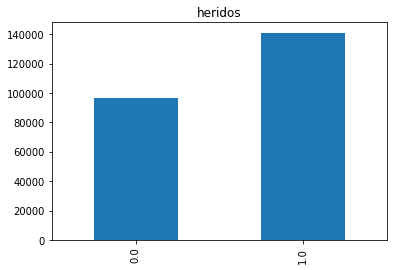

In [ ]:
#Modificacion heridos
plot= datos2['heridos'].value_counts().sort_index(ascending=True).plot(kind='bar',title="heridos");
plt.show(plot)

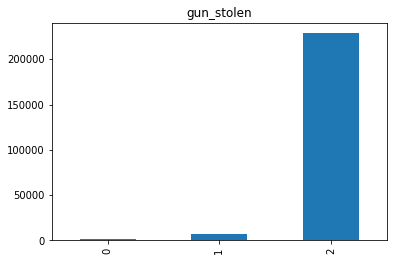

In [ ]:
#Armas robadas
plot= datos2['gun_stolen'].value_counts().sort_index(ascending=True).plot(kind='bar',title="gun_stolen");
plt.show(plot)

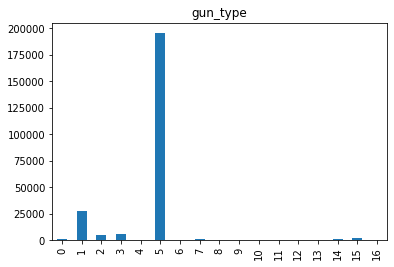

In [ ]:
#Tipo de armas
plot= datos2['gun_type'].value_counts().sort_index(ascending=True).plot(kind='bar',title="gun_type");
plt.show(plot)

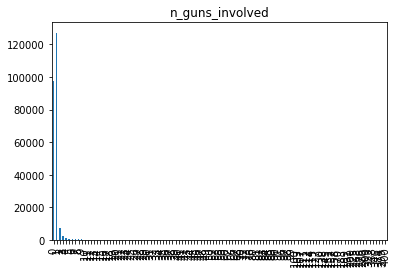

In [ ]:
#N° de armas involucradas
plot= datos2['n_guns_involved'].value_counts().sort_index(ascending=True).plot(kind='bar',title="n_guns_involved");
plt.show(plot)

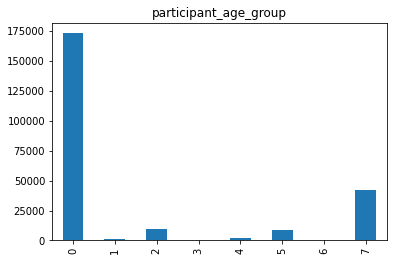

In [ ]:
#Edad del grupo particpante
plot= datos2['participant_age_group'].value_counts().sort_index(ascending=True).plot(kind='bar',title="participant_age_group");
plt.show(plot)

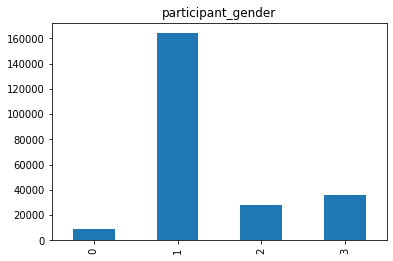

In [ ]:
#Generos de participantes
plot= datos2['participant_gender'].value_counts().sort_index(ascending=True).plot(kind='bar',title="participant_gender");
plt.show(plot)

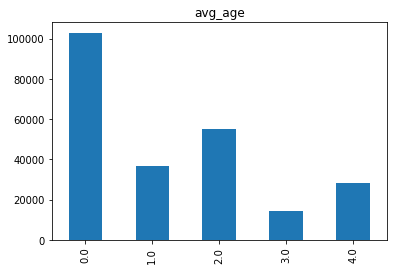

In [ ]:
#Edad promedio
plot= datos2['avg_age'].value_counts().sort_index(ascending=True).plot(kind='bar',title="avg_age");
plt.show(plot)

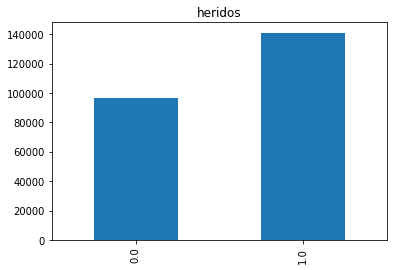

In [ ]:
#Edad promedio
plot= datos2['heridos'].value_counts().sort_index(ascending=True).plot(kind='bar',title="heridos");
plt.show(plot)

#**Boxplots**

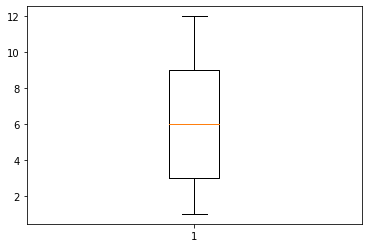

In [ ]:
#Mes
plt.boxplot(datos2['month'])
plt.show()

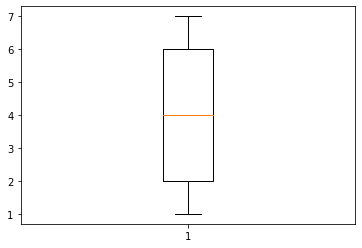

In [ ]:
#Day
plt.boxplot(datos2['day'])
plt.show()

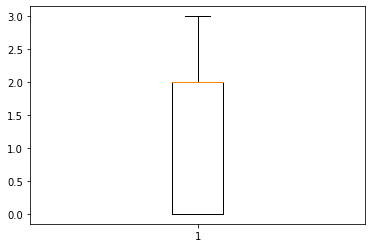

In [ ]:
#Estado
plt.boxplot(datos2['state2'])
plt.show()

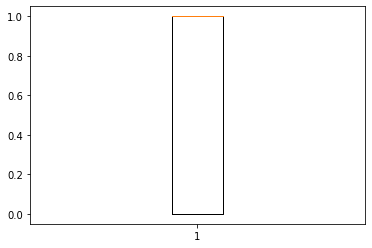

In [ ]:
plt.boxplot(datos2['heridos'])
plt.show()

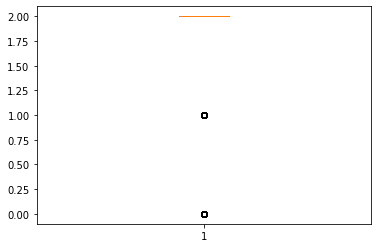

In [ ]:
#Armas robadas
plt.boxplot(datos2['gun_stolen'])
plt.show()

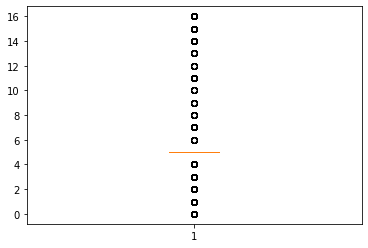

In [ ]:
#Tipo de armas
plt.boxplot(datos2['gun_type'])
plt.show()

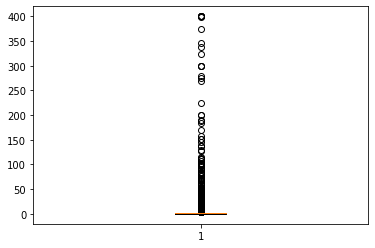

In [ ]:
#Numro de armas envueltas
plt.boxplot(datos2['n_guns_involved'])
plt.show()

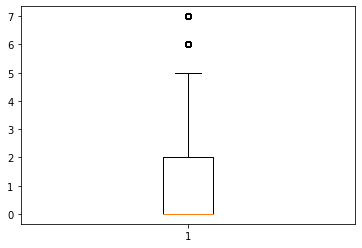

In [ ]:
#Edad del grupo de participantes
plt.boxplot(datos2['participant_age_group'])
plt.show()

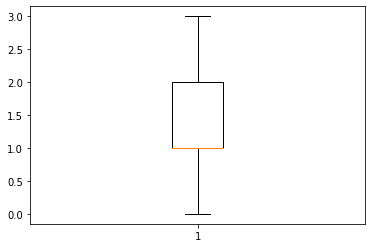

In [ ]:
#Genero de los participantes
plt.boxplot(datos2['participant_gender'])
plt.show()

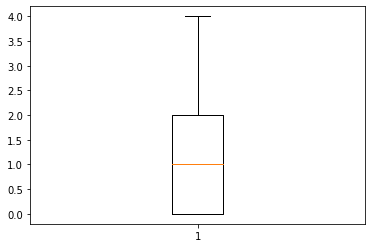

In [ ]:
#Edad promedio participantes
plt.boxplot(datos2['avg_age'])
plt.show()

In [ ]:
datos2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237497 entries, 0 to 239567
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   month                  237497 non-null  float64
 1   day                    237497 non-null  float64
 2   gun_stolen             237497 non-null  int64  
 3   gun_type               237497 non-null  int64  
 4   n_guns_involved        237497 non-null  int64  
 5   participant_age_group  237497 non-null  int64  
 6   participant_gender     237497 non-null  int64  
 7   avg_age                237497 non-null  float64
 8   heridos                237497 non-null  float64
 9   state2                 237497 non-null  float64
dtypes: float64(5), int64(5)
memory usage: 19.9 MB


In [ ]:
#Decisiones para eliminar outliers**

In [ ]:
gun_stolen_v2 = datos2[ (datos2['gun_stolen'] == 2)].index.astype(int)
datos2.drop(gun_stolen_v2, inplace=True)

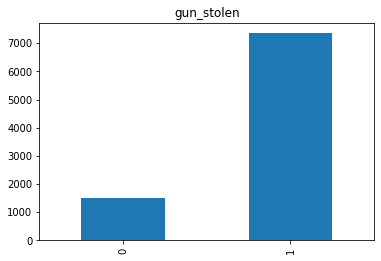

In [ ]:
#0 El arma no era robada, 1 usada era robada
plot= datos2['gun_stolen'].value_counts().sort_index(ascending=True).plot(kind='bar',title="gun_stolen");
plt.show(plot)

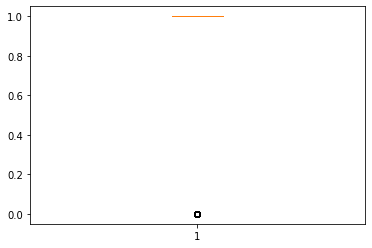

In [ ]:
plt.boxplot(datos2['gun_stolen'])
plt.show()

In [ ]:
datos2['gun_type']=(datos['gun_type'].fillna(0)).astype(int)
datos2.loc[(datos2.gun_type>=6),'gun_type']=4;
gun_type_v2 = datos2[ (datos2['gun_type'] == 5)].index.astype(int)
datos2.drop(gun_type_v2, inplace=True)

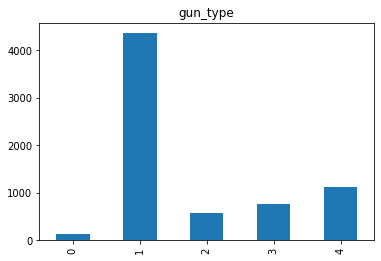

In [ ]:
#0	Gal, 1	Handgun, 2	Shotgun, 3	Rifle, 4	Other
plot= datos2['gun_type'].value_counts().sort_index(ascending=True).plot(kind='bar',title="gun_type");
plt.show(plot)

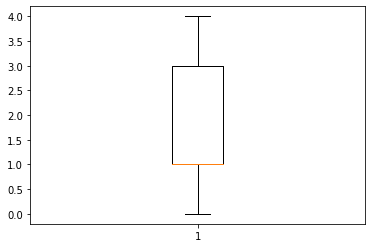

In [ ]:
plt.boxplot(datos2['gun_type'])
plt.show()

In [ ]:
n_guns_involved_v2 = datos2[ (datos2['n_guns_involved'] == 0)].index.astype(int)
datos2.drop(n_guns_involved_v2, inplace=True)
datos2['n_guns_involved']=(datos['n_guns_involved'].fillna(0)).astype(int)
datos2.loc[(datos2.n_guns_involved>=3),'n_guns_involved']=3;

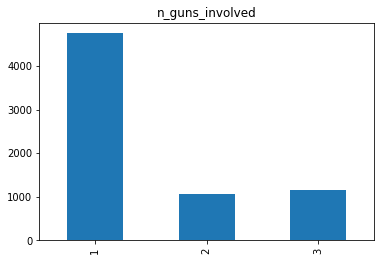

In [ ]:
#1 arma involucrada, 2 armas involucradas , 3 o mas armas
plot= datos2['n_guns_involved'].value_counts().sort_index(ascending=True).plot(kind='bar',title="n_guns_involved");
plt.show(plot)

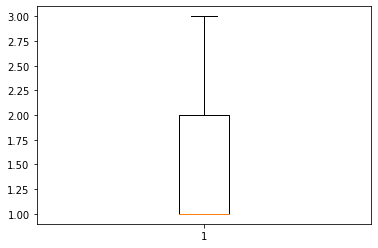

In [ ]:
plt.boxplot(datos2['n_guns_involved'])
plt.show()

In [ ]:
#0 mayores de edad (18) 1 menores edad
participant_age_group_v2 = datos2[ (datos2['participant_age_group'] == 7)].index.astype(int)
datos2.drop(participant_age_group_v2, inplace=True)
datos2['participant_age_group']=(datos['participant_age_group'].fillna(0)).astype(int)
datos2.loc[(datos2.participant_age_group==0)|(datos2.participant_age_group==4)|(datos2.participant_age_group==5),'participant_age_group']=0;
datos2.loc[(datos2.participant_age_group==1)|(datos2.participant_age_group==2)|(datos2.participant_age_group==3)|(datos2.participant_age_group==6),'participant_age_group']=1;



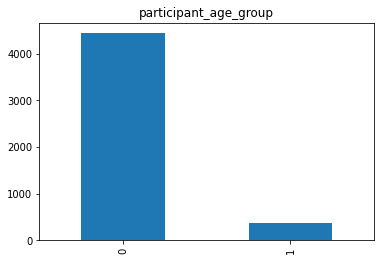

In [ ]:
plot= datos2['participant_age_group'].value_counts().sort_index(ascending=True).plot(kind='bar',title="participant_age_group");
plt.show(plot)

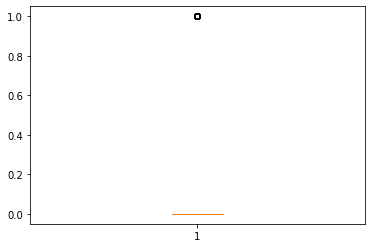

In [ ]:
plt.boxplot(datos2['participant_age_group'])
plt.show()

In [ ]:
datos2

month  day  gun_stolen  ...  avg_age  heridos  state2
54        4.0  7.0           0  ...      4.0      1.0     0.0
95        6.0  5.0           0  ...      4.0      1.0     2.0
207       9.0  2.0           1  ...      4.0      1.0     2.0
1124      1.0  2.0           1  ...      4.0      1.0     0.0
1136      1.0  2.0           0  ...      4.0      1.0     2.0
...       ...  ...         ...  ...      ...      ...     ...
239298    3.0  4.0           1  ...      0.0      0.0     1.0
239299    3.0  4.0           1  ...      0.0      0.0     1.0
239314    3.0  4.0           1  ...      2.0      0.0     3.0
239336    3.0  5.0           1  ...      0.0      1.0     1.0
239424    3.0  5.0           1  ...      2.0      0.0     2.0

[4807 rows x 10 columns]

#**Analisis estadistico**

In [ ]:
!pip install pandas-profiling==2.8.0
import pandas_profiling
from pandas_profiling import ProfileReport

In [ ]:
datos2.describe()

month          day  ...      heridos       state2
count  4807.00000  4807.000000  ...  4807.000000  4807.000000
mean      6.19638     3.932182  ...     0.197004     1.169544
std       3.60274     1.940967  ...     0.397777     0.997586
min       1.00000     1.000000  ...     0.000000     0.000000
25%       3.00000     2.000000  ...     0.000000     0.000000
50%       6.00000     4.000000  ...     0.000000     1.000000
75%       9.00000     6.000000  ...     0.000000     2.000000
max      12.00000     7.000000  ...     1.000000     3.000000

[8 rows x 10 columns]

In [ ]:
#se obtienen informacion sobre cada variable, como promedio, varianza, correlacion de person, entre otros
#profile = ProfileReport(datos2) 

In [ ]:
#profile

In [ ]:
datos2.drop(datos2[datos2.avg_age.isnull()].index, inplace = True)

#**Defenición de target y variables independientes**


In [ ]:
datos3=datos2.copy()
datos3 = datos3.drop(['heridos'], axis=1) #Eliminar columnas correlacionales a global_sales
variables_independientes = datos3
variables_independientes

month  day  gun_stolen  ...  participant_gender  avg_age  state2
54        4.0  7.0           0  ...                   2      4.0     0.0
95        6.0  5.0           0  ...                   2      4.0     2.0
207       9.0  2.0           1  ...                   1      4.0     2.0
1124      1.0  2.0           1  ...                   1      4.0     0.0
1136      1.0  2.0           0  ...                   1      4.0     2.0
...       ...  ...         ...  ...                 ...      ...     ...
239298    3.0  4.0           1  ...                   1      0.0     1.0
239299    3.0  4.0           1  ...                   1      0.0     1.0
239314    3.0  4.0           1  ...                   1      2.0     3.0
239336    3.0  5.0           1  ...                   2      0.0     1.0
239424    3.0  5.0           1  ...                   1      2.0     2.0

[4807 rows x 9 columns]

In [ ]:
variables_independientes.isnull().sum()

month                    0
day                      0
gun_stolen               0
gun_type                 0
n_guns_involved          0
participant_age_group    0
participant_gender       0
avg_age                  0
state2                   0
dtype: int64

In [ ]:
datos4=datos2.copy()
datos4 = datos4.drop(['month','day','state2','gun_stolen','gun_type','n_guns_involved','participant_age_group','participant_gender','avg_age'], axis=1) #Eliminar columnas correlacionales a global_sales
variables_objetivo = datos4
variables_objetivo

heridos
54          1.0
95          1.0
207         1.0
1124        1.0
1136        1.0
...         ...
239298      0.0
239299      0.0
239314      0.0
239336      1.0
239424      0.0

[4807 rows x 1 columns]

In [ ]:
datos3.astype(int)
datos4.astype(int)

heridos
54            1
95            1
207           1
1124          1
1136          1
...         ...
239298        0
239299        0
239314        0
239336        1
239424        0

[4807 rows x 1 columns]

#**Normalizaciones**

**Se debe escoger entre 1 de los 3 procesos a continuación, obviamente el que entregue mejores resultados**

**Rama 1, sin normalizar**

In [ ]:
#X_std = variables_independientes.values
#X_stdo = variables_objetivo.values

**Rama 2,Normalizado**

In [ ]:
#X_std = preprocessing.normalize(variables_independientes)
#X_stdo = preprocessing.normalize(variables_objetivo)

**Rama 3,MinMaxScaler**

In [ ]:
#X_std = preprocessing.minmax_scale(variables_independientes)
#X_stdo = preprocessing.minmax_scale(variables_objetivo)

**Rama 4,Scale**

In [ ]:
X_std = preprocessing.scale(variables_independientes) # Se considera como la normalización con mejor resultado
X_stdo = preprocessing.scale(variables_objetivo) # Se considera como la normalización con mejor resultado

In [ ]:
X_std

array([[-0.60970501,  1.58072624, -2.20828624, ...,  1.97251282,
         1.71607568, -1.1724969 ],
       [-0.05451426,  0.55020464, -2.20828624, ...,  1.97251282,
         1.71607568,  0.83255205],
       [ 0.77827187, -0.99557777,  0.45283985, ..., -0.25223357,
         1.71607568,  0.83255205],
       ...,
       [-0.88730039,  0.03494384,  0.45283985, ..., -0.25223357,
         0.19870682,  1.83507652],
       [-0.88730039,  0.55020464,  0.45283985, ...,  1.97251282,
        -1.31866204, -0.16997242],
       [-0.88730039,  0.55020464,  0.45283985, ..., -0.25223357,
         0.19870682,  0.83255205]])

In [ ]:
X_stdo

array([[ 2.01891792],
       [ 2.01891792],
       [ 2.01891792],
       ...,
       [-0.49531484],
       [ 2.01891792],
       [-0.49531484]])

#**Clusters**

In [ ]:
from sklearn import cluster
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage  
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  """
/usr/local/lib/python3.7/d

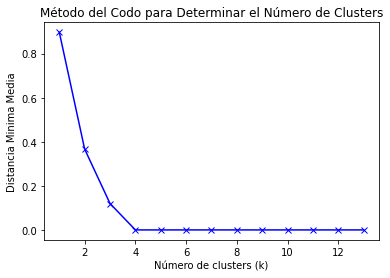

In [ ]:
##Para los muertos
distortions = []
K = range(1,14)
for k in K:
    kmeanModel = cluster.KMeans(n_clusters=k).fit(datos4[['heridos']])
    kmeanModel.fit(datos4[['heridos']])
    distortions.append(sum(np.min(cdist(datos4[['heridos']], kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / datos4[['heridos']].shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Distancia Minima Media')
plt.title('Método del Codo para Determinar el Número de Clusters')
plt.show()

**KNN 3 Grupos**

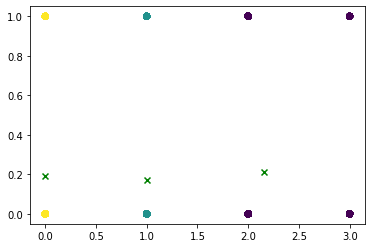

In [ ]:
kmeans = cluster.KMeans(3)
kmeans.fit(datos2[['heridos', 'state2']])
labels = kmeans.labels_
centroids3 = kmeans.cluster_centers_
plt.scatter( datos2['heridos'],datos2['state2'], c=labels)
plt.scatter(centroids3[:,0], centroids3[:,1], marker='x', c='green')
plt.show()

In [ ]:
# Valores de los centroides
centroids3

array([[1.91588785e-01, 1.28785871e-14],
       [2.10887466e-01, 2.15599268e+00],
       [1.73817382e-01, 1.00000000e+00]])

**KNN 4 Grupos**

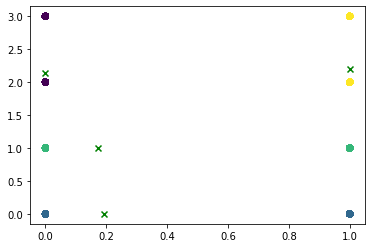

In [ ]:
kmeans = cluster.KMeans(4)
kmeans.fit(datos2[[ 'heridos','state2']])
labels = kmeans.labels_
centroids4 = kmeans.cluster_centers_
plt.scatter( datos2['heridos'],datos2['state2'], c=labels)
plt.scatter(centroids4[:,0], centroids4[:,1], marker='x', c='green')
plt.show()

In [ ]:
# Valores de los centroides
centroids4

array([[-5.46784840e-15,  2.14376812e+00],
       [ 1.91588785e-01,  1.28785871e-14],
       [ 1.73817382e-01,  1.00000000e+00],
       [ 1.00000000e+00,  2.20173536e+00]])

**KNN 5 Grupos**

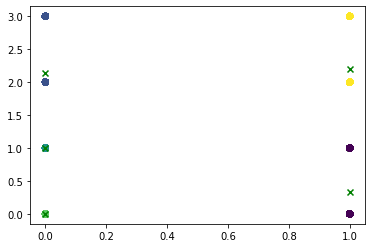

In [ ]:
kmeans = cluster.KMeans(5)
kmeans.fit(datos2[['heridos', 'state2']])
labels = kmeans.labels_
centroids5 = kmeans.cluster_centers_
plt.scatter(datos2['heridos'], datos2['state2'], c=labels)
plt.scatter(centroids5[:,0], centroids5[:,1], marker='x', c='green')
plt.show()

In [ ]:
# Valores de los centroides
centroids5

array([[ 1.00000000e+00,  3.25102881e-01],
       [-5.46784840e-15,  2.14376812e+00],
       [ 1.19348975e-15,  1.00000000e+00],
       [-2.49800181e-16,  1.26565425e-14],
       [ 1.00000000e+00,  2.20173536e+00]])

**KNN 6 Grupos**


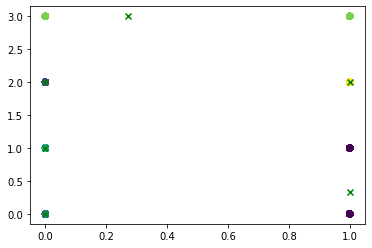

In [ ]:
kmeans = cluster.KMeans(6)
kmeans.fit(datos2[['heridos','state2']])
labels = kmeans.labels_
centroids6 = kmeans.cluster_centers_
plt.scatter(datos2['heridos'],datos2['state2'], c=labels)
plt.scatter(centroids6[:,0], centroids6[:,1], marker='x', c='green')
plt.show()

In [ ]:
# Valores de los centroides
centroids6

array([[ 1.00000000e+00,  3.25102881e-01],
       [-1.91513472e-15,  2.00000000e+00],
       [-2.49800181e-16,  1.26565425e-14],
       [ 1.19348975e-15,  1.00000000e+00],
       [ 2.72727273e-01,  3.00000000e+00],
       [ 1.00000000e+00,  2.00000000e+00]])

**KNN 7 Grupos**

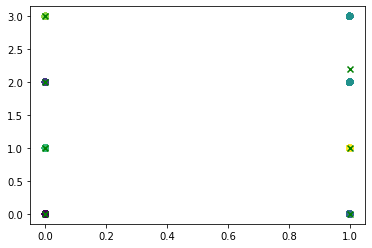

In [ ]:
kmeans = cluster.KMeans(7)
kmeans.fit(datos2[['heridos','state2']])
labels = kmeans.labels_
centroids7 = kmeans.cluster_centers_
plt.scatter(datos2['heridos'],datos2['state2'], c=labels)
plt.scatter(centroids7[:,0], centroids7[:,1], marker='x', c='green')
plt.show()

In [ ]:
# Valores de los centroides
centroids7

array([[-2.49800181e-16,  1.26565425e-14],
       [-1.91513472e-15,  2.00000000e+00],
       [ 1.00000000e+00,  9.10382880e-15],
       [ 1.00000000e+00,  2.20173536e+00],
       [ 1.19348975e-15,  1.00000000e+00],
       [ 5.55111512e-17,  3.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00]])

In [ ]:
from scipy.spatial.distance import pdist, squareform

In [ ]:
clustdf_t=datos2.transpose()
c_dist = pdist(clustdf_t) # computing the distance
c_link = linkage(clustdf_t,  metric='correlation', method='complete')# computing the linkage

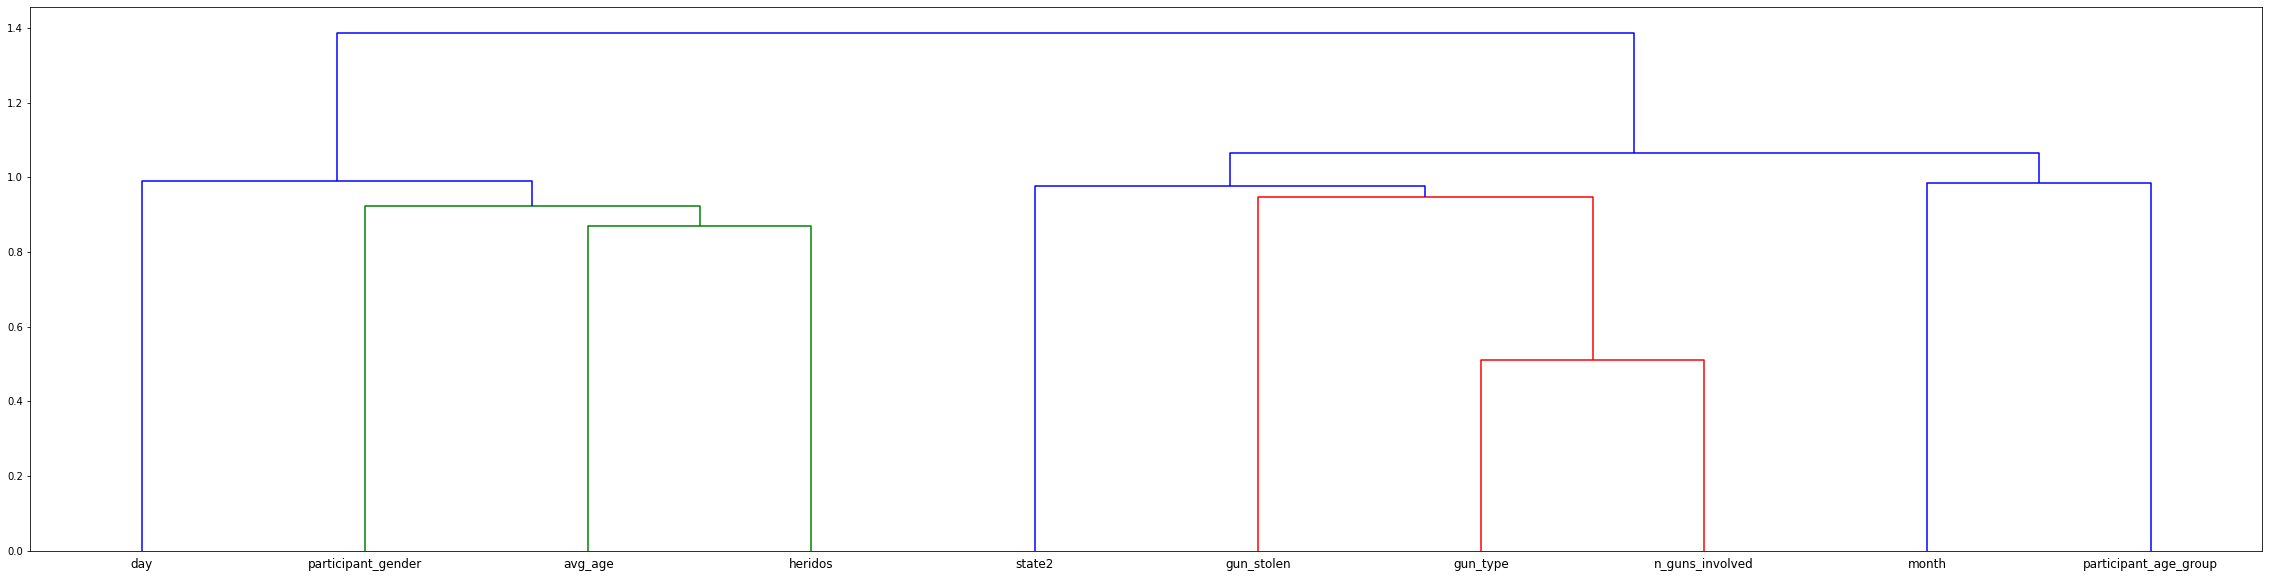

In [ ]:
plt.figure(figsize=(40, 10))
dendrogram(c_link,labels=list(datos2.columns))
plt.show()

#**Analisis PCA y Factorial**

In [ ]:
!pip3 install mglearn

In [ ]:
!pip install factor_analyzer==0.2.3

In [ ]:
from factor_analyzer import FactorAnalyzer

In [ ]:
#import mglearn

In [ ]:
X_std.shape #variables independientes

(4807, 9)

In [ ]:
X_stdo.shape #variable objetivo

(4807, 1)

**Matriz de covarianza**

In [ ]:
print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

NumPy covariance matrix: 
[[ 1.00020807  0.01166712  0.01485411  0.02110013  0.00135682  0.01419538
  -0.01028364  0.01398977  0.01389455]
 [ 0.01166712  1.00020807 -0.03665449 -0.02766819 -0.02827941 -0.01350661
   0.00857732  0.02217472  0.02163319]
 [ 0.01485411 -0.03665449  1.00020807  0.05294804  0.16935451  0.04444197
  -0.01386851 -0.06017466  0.02258582]
 [ 0.02110013 -0.02766819  0.05294804  1.00020807  0.48878167 -0.02070267
   0.04638043  0.0347016   0.03955073]
 [ 0.00135682 -0.02827941  0.16935451  0.48878167  1.00020807 -0.0656629
   0.08359476  0.08261934  0.03368209]
 [ 0.01419538 -0.01350661  0.04444197 -0.02070267 -0.0656629   1.00020807
   0.05140797 -0.28813288 -0.00408573]
 [-0.01028364  0.00857732 -0.01386851  0.04638043  0.08359476  0.05140797
   1.00020807  0.10807942 -0.00621945]
 [ 0.01398977  0.02217472 -0.06017466  0.0347016   0.08261934 -0.28813288
   0.10807942  1.00020807 -0.04155026]
 [ 0.01389455  0.02163319  0.02258582  0.03955073  0.03368209 -0.004085

**Vectores con valores eigen**

In [ ]:
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.02848378  0.02919766 -0.07186734 -0.03000355 -0.27268951 -0.37004422
   0.87207012 -0.0848263   0.11522568]
 [-0.05795526 -0.00561206 -0.01126722  0.13126684 -0.06532372 -0.68612957
  -0.20401462  0.14475497 -0.6645561 ]
 [ 0.21901589 -0.18423317  0.02272022 -0.33926305 -0.19054086  0.19229186
   0.10806989  0.83920148 -0.11512756]
 [ 0.6237358  -0.66184009  0.01870332 -0.14986358  0.00265303 -0.04053968
  -0.04016397 -0.36852214 -0.10507247]
 [ 0.66950963  0.71963008 -0.01059689 -0.11945642  0.00275524  0.01477537
  -0.03697203 -0.07770158 -0.10898122]
 [-0.17384669  0.06036386  0.64380474 -0.61481183  0.36086843 -0.16674328
   0.0711952  -0.09975862 -0.02460729]
 [ 0.16408743 -0.05817722 -0.3219363   0.0941733   0.75894225 -0.32468856
   0.05812467  0.27330122  0.31255576]
 [ 0.21963755 -0.04681669  0.68392155  0.65262729  0.04855258  0.00968195
   0.09820772  0.18682113  0.09433182]
 [ 0.07200275  0.00736201  0.08862063 -0.13136163 -0.42009055 -0.46918635
  -0.406

In [ ]:
#  lista de (autovector, autovalor) 
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Orden descendiente con la función sort
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visualizamos la lista de autovalores en orden desdenciente
print('Autovalores en orden descendiente:')
for i in eig_pairs:
    print(i[0])

Autovalores en orden descendiente:
1.5817429204927986
1.3076116953877954
1.0419129706607788
1.03100402914534
0.9938647189721046
0.9545086051858521
0.9323755756812351
0.668551437373432
0.49030070627669436


[17.571265228690542, 14.525996366488092, 11.574402461677883, 11.453217215802193, 11.0406440593115, 10.603444875582378, 10.357573484788423, 7.426803984968018, 5.446652322690966] var 

[ 17.57126523  32.0972616   43.67166406  55.12488127  66.16552533
  76.76897021  87.12654369  94.55334768 100.        ] cum



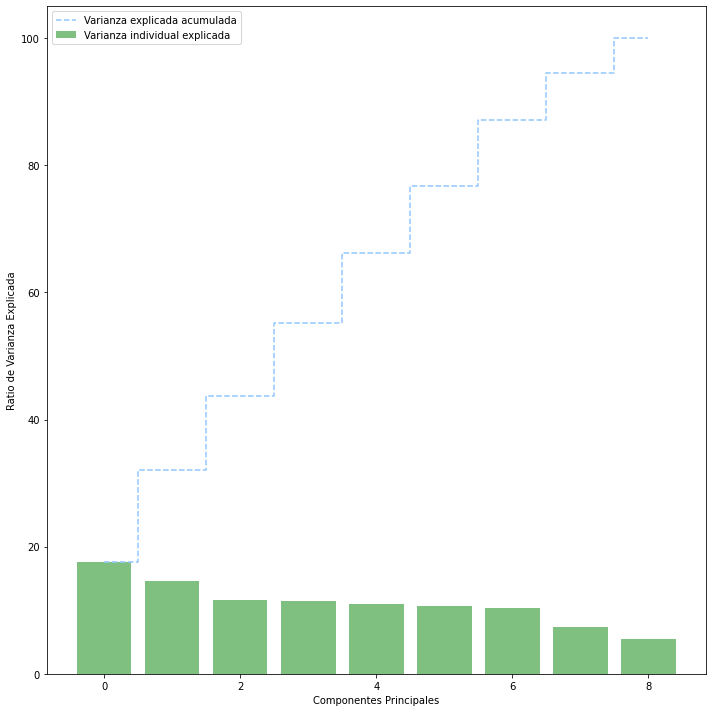

In [ ]:
# A partir de los autovalores, se calcula la varianza  ##Verificar si el valor 9 va ahí
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(var_exp, 'var \n')
print(cum_var_exp, 'cum\n')
with plt.style.context('seaborn-pastel'):
     plt.figure(figsize=(10, 10))
     plt.bar(range(9), var_exp, alpha=0.5, align='center',label='Varianza individual explicada', color='g')
     plt.step(range(9), cum_var_exp, where='mid', linestyle='--', label='Varianza explicada acumulada')
     plt.ylabel('Ratio de Varianza Explicada')
     plt.xlabel('Componentes Principales')
     plt.legend(loc='best')
     plt.tight_layout()
# Representamos en un diagrama de barras la varianza por cada autovalor, y la acumulada

**PCA**

In [ ]:
pca = PCA(n_components=2)
pca.fit(X_std)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
#se transforma los datos, reduciendo los componentes
transformado = pca.transform(X_std)

print(X_std.shape)
print(transformado.shape)


(4807, 9)
(4807, 2)


In [ ]:
transformado

array([[ 1.72923153, -2.24359224],
       [ 1.94913865, -1.82827474],
       [ 0.69275288, -0.86946229],
       ...,
       [-0.03656582,  0.03556326],
       [ 0.1820509 ,  0.51700236],
       [-0.6677687 , -0.29090583]])

**Analisis Factorial**

In [ ]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(variables_independientes)
chi_square_value, p_value

(2120.9342335965944, 0.0)

In [ ]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(variables_independientes)

In [ ]:
# Se crea el factor de analisis y el desempeño de este  #Verificar ese 9
fa = FactorAnalyzer()
fa.analyze(variables_independientes, 2, rotation=None)
# Se checkea el eigenvelues
ev, v = fa.get_eigenvalues()
ev

Original_Eigenvalues
0              1.581414
1              1.307340
2              1.041696
3              1.030790
4              0.993658
5              0.954310
6              0.932182
7              0.668412
8              0.490199

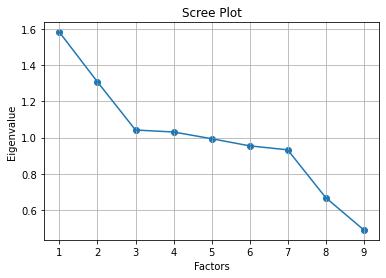

In [ ]:
# Se grafica
plt.scatter(range(1,variables_independientes.shape[1]+1),ev)
plt.plot(range(1,variables_independientes.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [ ]:
# Se crea el factor de analisis y el desempeño de este usando 10 factores revisar esto también
fa = FactorAnalyzer()
fa.analyze(datos3, 3, rotation="varimax")
fa.loadings

Factor1   Factor2   Factor3
month                  0.010316  0.013525  0.009615
day                   -0.038089 -0.009022  0.046034
gun_stolen             0.164527  0.034993 -0.121154
gun_type               0.486081  0.015432  0.025063
n_guns_involved        0.997454  0.006512  0.046502
participant_age_group -0.064715  0.982228 -0.162060
participant_gender     0.074251  0.093049  0.220219
avg_age                0.057227 -0.198040  0.552002
state2                 0.047068 -0.011283 -0.075211

In [ ]:
# Se obtiene la varianza
fa.get_factor_variance()

Factor1   Factor2   Factor3
SS Loadings     1.275008  1.014547  0.404803
Proportion Var  0.141668  0.112727  0.044978
Cumulative Var  0.141668  0.254395  0.299373

Para este caso, se eligen el dataset que se ocupará, donde por defecto se utilizó el dataset con los outliers ya tratados, con el fin de minimizar el impacto que tendrá en los resultados de predicción. Al ejecutar todo de forma secuencial, se tomará este mismo dataset anteriormente mencionado.

# **Arboles de decisión**

**Arbol de decision Gini**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

# Separamos en dos variables (X e Y)
X = datos3
Y = datos4['heridos']

# Separando los datos en sets de entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [ ]:
# Importando el arbol de decisión
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

# Creando el modelo con criterio 'gini'
arbolGini = DecisionTreeClassifier(criterion='gini') 

# Ajustando el modelo
arbolGini.fit(X_train, y_train)

print('Precisión modelo inicial train/test  {0:.6f}/{1:.6f}'
      .format(arbolGini.score(X_train, y_train), arbolGini.score(X_test, y_test)))

Precisión modelo inicial train/test  0.964889/0.756757


In [ ]:
from sklearn.metrics import confusion_matrix

y_predicted_arbolGini = arbolGini.predict(X_test)
matrizC = confusion_matrix(y_test, y_predicted_arbolGini)
matrizC

array([[665, 108],
       [126,  63]])

Text(69.0, 0.5, 'Truth')

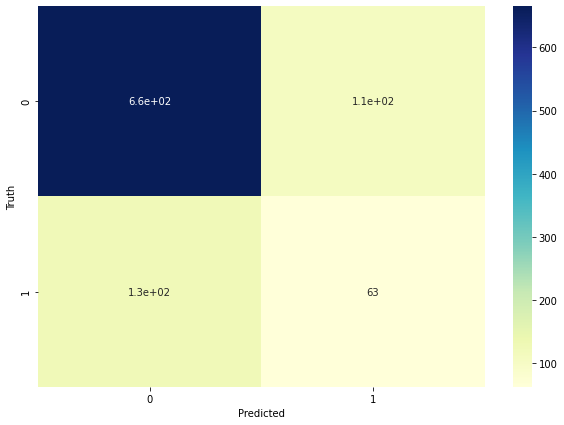

In [ ]:
import seaborn as sns

%matplotlib inline
plt.figure(figsize=(10,7))
sns.heatmap(matrizC, annot=True, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Truth')

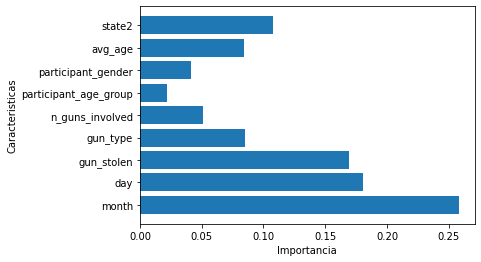

In [ ]:
caract = X.shape[1]
plt.barh(range(caract), arbolGini.feature_importances_)
plt.yticks(np.arange(caract), X.columns.values)
plt.xlabel('Importancia')
plt.ylabel('Caracteristicas')
plt.show()

**Arbol decision Cross Entropy**

In [ ]:
# Creando el modelo con criterio 'Entropy'
arbolEntropy = DecisionTreeClassifier(criterion='entropy') 
# Ajustando el modelo
arbolEntropy.fit(X_train, y_train) 
print('Precisión modelo inicial train/test  {0:.6f}/{1:.6f}'
      .format(arbolEntropy.score(X_train, y_train), arbolEntropy.score(X_test, y_test)))

Precisión modelo inicial train/test  0.964889/0.754678


In [ ]:
y_predicted_arbolEntropy = arbolEntropy.predict(X_test)
matrizC = confusion_matrix(y_test, y_predicted_arbolEntropy)
matrizC

array([[663, 110],
       [126,  63]])

Text(69.0, 0.5, 'Truth')

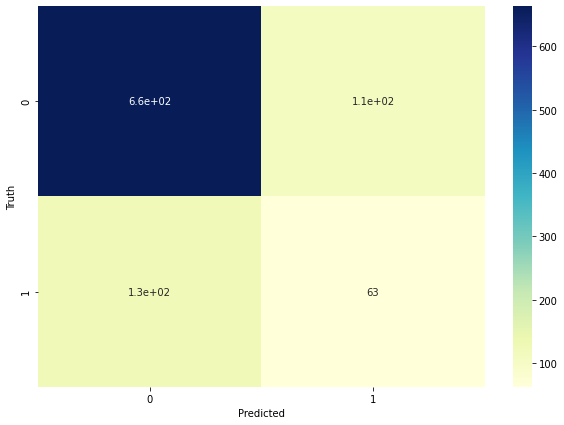

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,7))
sns.heatmap(matrizC, annot=True, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Truth')

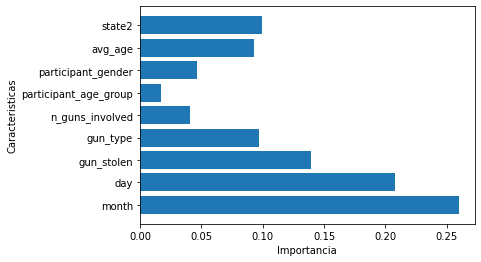

In [ ]:
caract = X.shape[1]
plt.barh(range(caract), arbolEntropy.feature_importances_)
plt.yticks(np.arange(caract), X.columns.values)
plt.xlabel('Importancia')
plt.ylabel('Caracteristicas')
plt.show()

**Random Forest**

In [ ]:
# Importando el random forest
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier() # Creando el modelo
randomForest.fit(X_train, y_train) # Ajustando el modelo

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print('Precisión modelo inicial train/test  {0:.6f}/{1:.6f}'
      .format(randomForest.score(X_train, y_train), randomForest.score(X_test, y_test)))

Precisión modelo inicial train/test  0.964889/0.793139


In [ ]:
y_predicted_randomForest = randomForest.predict(X_test)
matrizC = confusion_matrix(y_test, y_predicted_randomForest)
matrizC

array([[699,  74],
       [125,  64]])

Text(69.0, 0.5, 'Truth')

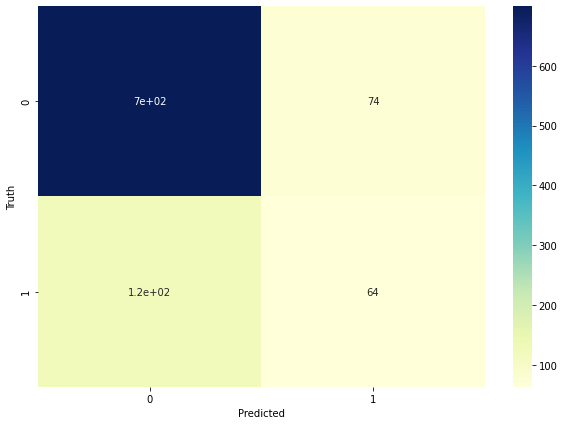

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,7))
sns.heatmap(matrizC, annot=True, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Truth')

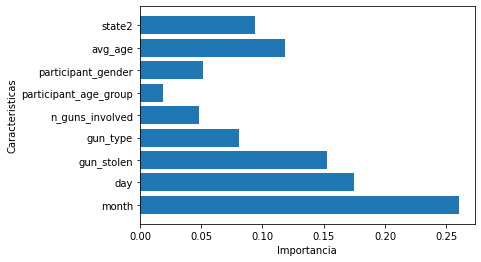

In [ ]:
caract = X.shape[1]
plt.barh(range(caract), randomForest.feature_importances_)
plt.yticks(np.arange(caract), X.columns.values)
plt.xlabel('Importancia')
plt.ylabel('Caracteristicas')
plt.show()

**AdaBoost**

In [ ]:
# Importando adaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

# Utilizando AdaBoost
adaBoost = AdaBoostClassifier(n_estimators=500, 
                              learning_rate=1.5)
# Ajustando los datos
adaBoost = adaBoost.fit(X_train, y_train)

In [ ]:
print('Precisión modelo inicial train/test  {0:.6f}/{1:.6f}'
      .format(adaBoost.score(X_train, y_train), adaBoost.score(X_test, y_test)))

Precisión modelo inicial train/test  0.829129/0.829522


In [ ]:
y_predicted_adaBoost = adaBoost.predict(X_test)
matrizC = confusion_matrix(y_test, y_predicted_adaBoost)
matrizC

array([[734,  39],
       [125,  64]])

Text(69.0, 0.5, 'Truth')

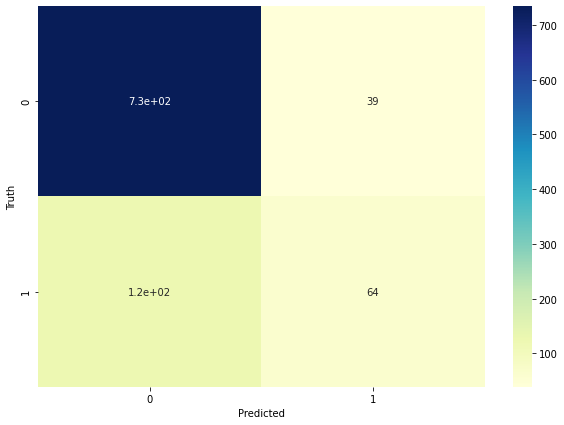

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,7))
sns.heatmap(matrizC, annot=True, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Truth')

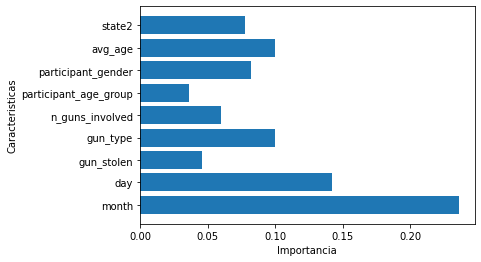

In [ ]:
caract = X.shape[1]
plt.barh(range(caract), adaBoost.feature_importances_)
plt.yticks(np.arange(caract), X.columns.values)
plt.xlabel('Importancia')
plt.ylabel('Caracteristicas')
plt.show()

**Gaussian Naive Bayes**

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html?highlight=gaussiannb#sklearn.naive_bayes.GaussianNB

from sklearn.naive_bayes import GaussianNB

gNaiveBayes = GaussianNB()
gNaiveBayes.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
print('Precisión modelo inicial train/test  {0:.6f}/{1:.6f}'
      .format(gNaiveBayes.score(X_train, y_train), gNaiveBayes.score(X_test, y_test)))

Precisión modelo inicial train/test  0.811964/0.804574


In [ ]:
#Matriz de Confusión
y_predicted_gNaiveBayes = gNaiveBayes.predict(X_test)
matrizC = confusion_matrix(y_test, y_predicted_gNaiveBayes)
matrizC

array([[681,  92],
       [ 96,  93]])

Text(69.0, 0.5, 'Truth')

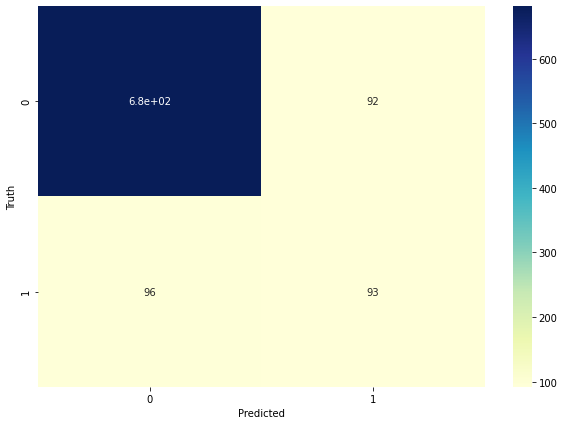

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,7))
sns.heatmap(matrizC, annot=True, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Truth')

#**Evaluación**

In [ ]:
from sklearn.model_selection import cross_val_score

score_arbolGini = cross_val_score(arbolGini, X, Y, cv=100)
scoreFinal_arbolGini = score_arbolGini.mean()*100
print(scoreFinal_arbolGini)

73.78954081632654


In [ ]:
score_arbolEntropy = cross_val_score(arbolEntropy, X, Y, cv=100)
scoreFinal_arbolEntropy = score_arbolEntropy.mean()*100
print(scoreFinal_arbolEntropy)

73.23044217687074


In [ ]:
score_randomForest = cross_val_score(randomForest, X, Y, cv=100)
scoreFinal_randomForest = score_randomForest.mean()*100
print(scoreFinal_randomForest)

78.74149659863944


In [ ]:
score_adaBoost = cross_val_score(adaBoost, X, Y, cv=100)
scoreFinal_adaBoost = score_adaBoost.mean()*100
print(scoreFinal_adaBoost)


81.63477891156464


In [ ]:
score_gNaiveBayes = cross_val_score(gNaiveBayes, X, Y, cv=100)
scoreFinal_gNaiveBayes = score_gNaiveBayes.mean()*100
print(scoreFinal_gNaiveBayes)

81.11607142857143


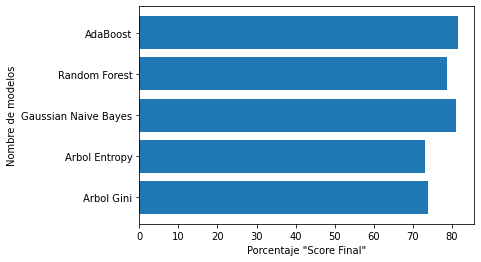

In [ ]:
import matplotlib.pyplot as plt

nombres = ['Arbol Gini','Arbol Entropy','Gaussian Naive Bayes','Random Forest','AdaBoost']
datos = [scoreFinal_arbolGini,scoreFinal_arbolEntropy,scoreFinal_gNaiveBayes,scoreFinal_randomForest,scoreFinal_adaBoost]
xx = range(len(datos))

plt.barh(xx, datos)
plt.yticks(xx, nombres)
plt.xlabel('Porcentaje "Score Final"')
plt.ylabel('Nombre de modelos')
plt.show()

#**Arboles con profundidad 3,5,6 (Arbol de decisión, AdaBoost)**

**Arbol profundidad 3**

In [ ]:
#se define el modelo del arbol de profundidad 3
modelo = DecisionTreeRegressor( 
            max_depth         = 3,
            random_state = 123
          )

In [ ]:
modelo.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=123, splitter='best')

Profundidad del árbol: 3
Número de nodos terminales: 8


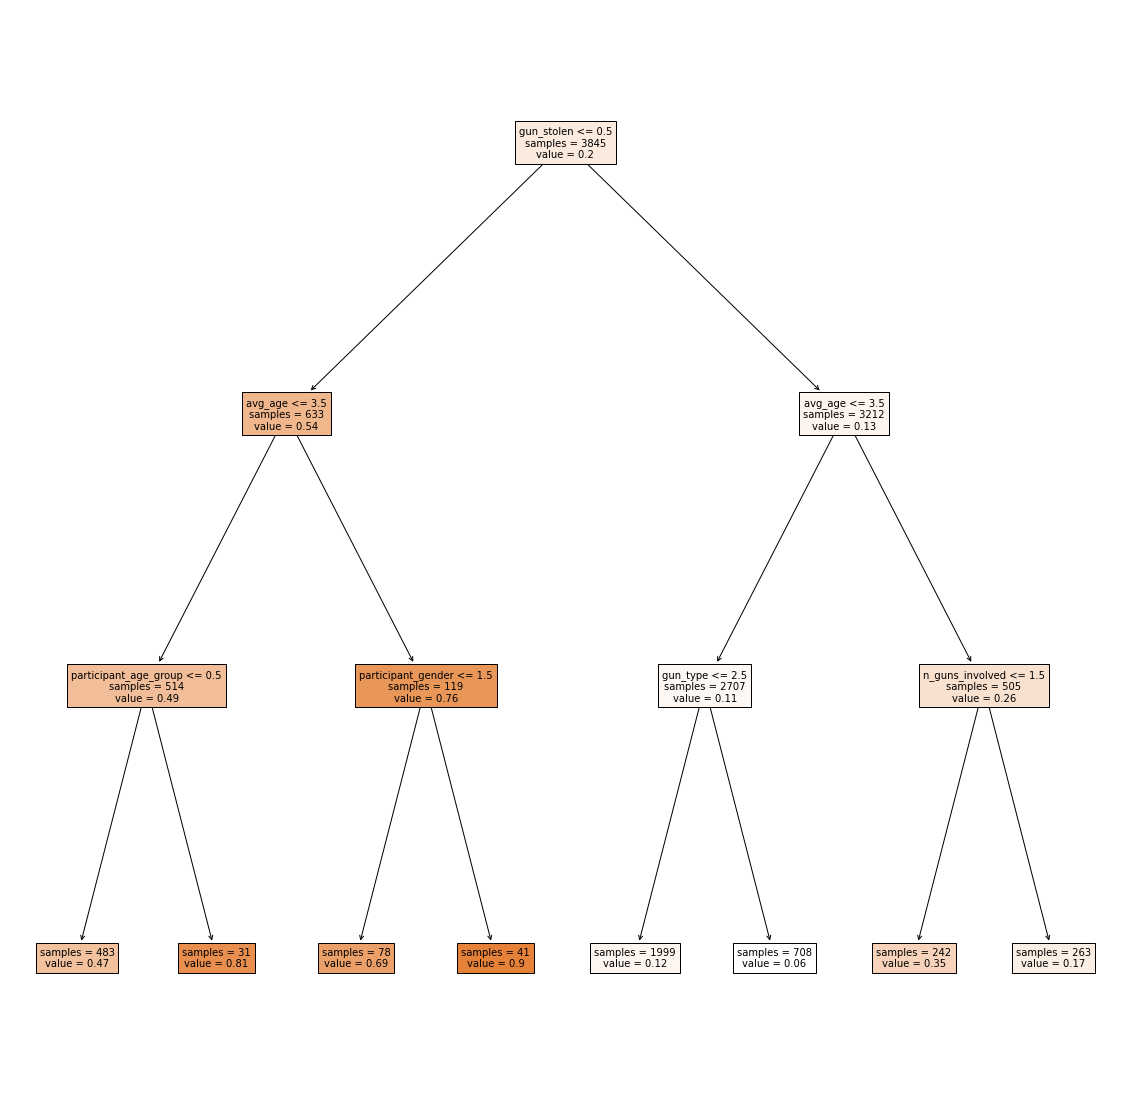

In [ ]:
#se grafica el arbol
fig, ax = plt.subplots(figsize=(20, 20))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = variables_independientes.columns,
            class_names   = 'Numero de muertes',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

In [ ]:
texto_modelo = export_text(# se obtinen los textos del arbol
                    decision_tree = modelo,
                    feature_names = list(variables_independientes.columns)
               )
print(texto_modelo)

|--- gun_stolen <= 0.50
|   |--- avg_age <= 3.50
|   |   |--- participant_age_group <= 0.50
|   |   |   |--- value: [0.47]
|   |   |--- participant_age_group >  0.50
|   |   |   |--- value: [0.81]
|   |--- avg_age >  3.50
|   |   |--- participant_gender <= 1.50
|   |   |   |--- value: [0.69]
|   |   |--- participant_gender >  1.50
|   |   |   |--- value: [0.90]
|--- gun_stolen >  0.50
|   |--- avg_age <= 3.50
|   |   |--- gun_type <= 2.50
|   |   |   |--- value: [0.12]
|   |   |--- gun_type >  2.50
|   |   |   |--- value: [0.06]
|   |--- avg_age >  3.50
|   |   |--- n_guns_involved <= 1.50
|   |   |   |--- value: [0.35]
|   |   |--- n_guns_involved >  1.50
|   |   |   |--- value: [0.17]



In [ ]:
importancia_predictores = pd.DataFrame( # se obtiene la importancion de cada predictor utilizado en el arbol
                            {'predictor': variables_independientes.columns,
                             'importancia': modelo.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


predictor  importancia
2             gun_stolen     0.762902
7                avg_age     0.145122
4        n_guns_involved     0.034649
5  participant_age_group     0.027941
3               gun_type     0.019332
6     participant_gender     0.010053
0                  month     0.000000
1                    day     0.000000
8                 state2     0.000000

In [ ]:
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.3592929693898291


In [ ]:
acc_decision_test = round(modelo.score(X_test, y_test) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_test, "%")

precisión:  18.23 %


In [ ]:
acc_decision_train = round(modelo.score(X_train, y_train) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_train, "%")

precisión:  19.4 %


**Arbol Profudidad 4**

In [ ]:
modelo4 = DecisionTreeRegressor(
            max_depth         = 4,
            random_state = 123
          )

In [ ]:
modelo4.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=123, splitter='best')

Profundidad del árbol: 4
Número de nodos terminales: 16


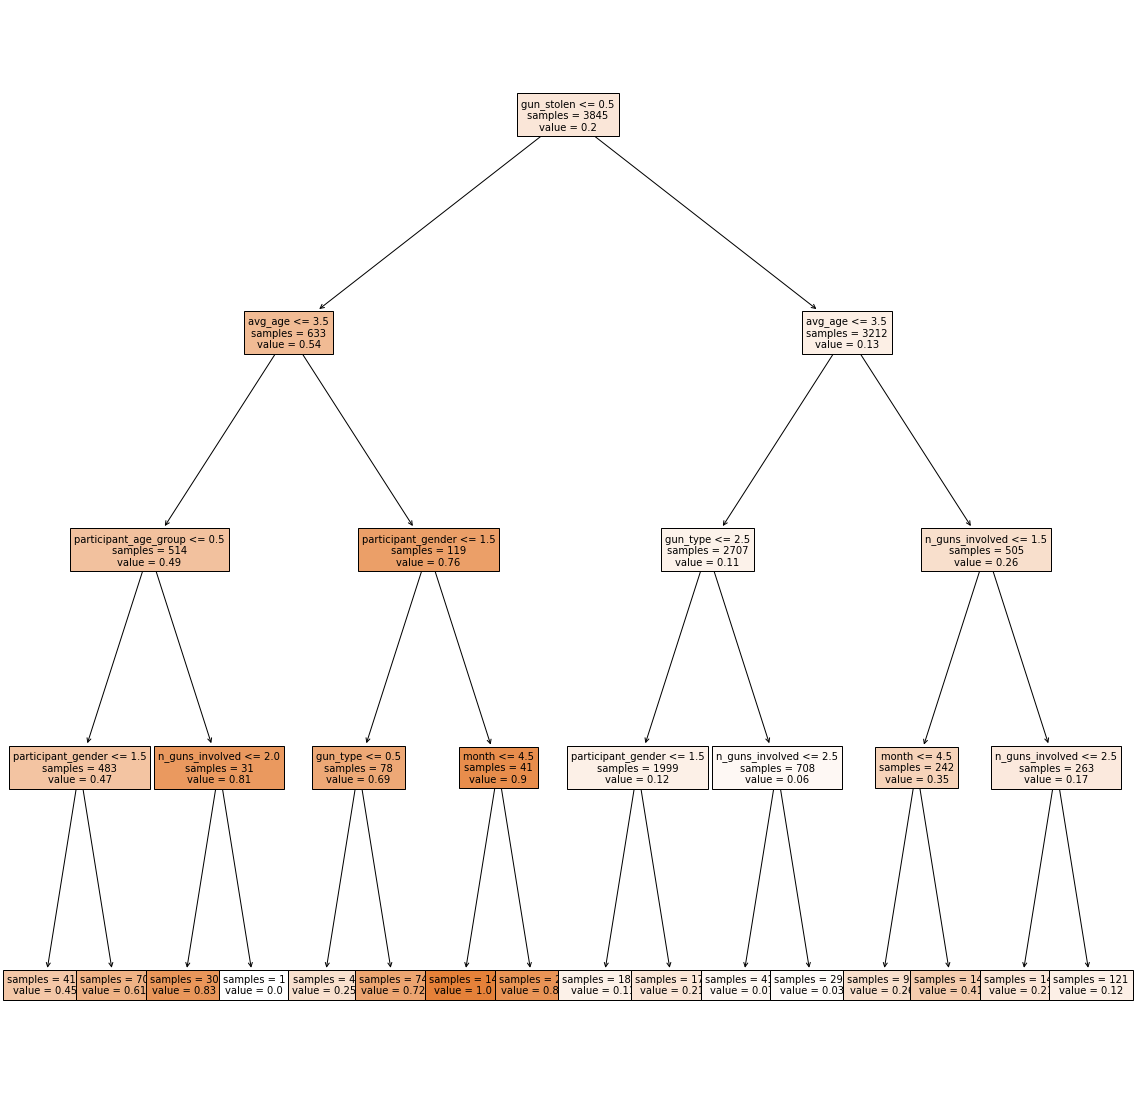

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))

print(f"Profundidad del árbol: {modelo4.get_depth()}")
print(f"Número de nodos terminales: {modelo4.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo4,
            feature_names = variables_independientes.columns,
            class_names   = 'Numero de muertos',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

In [ ]:
texto_modelo4 = export_text(
                    decision_tree = modelo4,
                    feature_names = list(variables_independientes.columns)
               )
print(texto_modelo4)

|--- gun_stolen <= 0.50
|   |--- avg_age <= 3.50
|   |   |--- participant_age_group <= 0.50
|   |   |   |--- participant_gender <= 1.50
|   |   |   |   |--- value: [0.45]
|   |   |   |--- participant_gender >  1.50
|   |   |   |   |--- value: [0.61]
|   |   |--- participant_age_group >  0.50
|   |   |   |--- n_guns_involved <= 2.00
|   |   |   |   |--- value: [0.83]
|   |   |   |--- n_guns_involved >  2.00
|   |   |   |   |--- value: [0.00]
|   |--- avg_age >  3.50
|   |   |--- participant_gender <= 1.50
|   |   |   |--- gun_type <= 0.50
|   |   |   |   |--- value: [0.25]
|   |   |   |--- gun_type >  0.50
|   |   |   |   |--- value: [0.72]
|   |   |--- participant_gender >  1.50
|   |   |   |--- month <= 4.50
|   |   |   |   |--- value: [1.00]
|   |   |   |--- month >  4.50
|   |   |   |   |--- value: [0.85]
|--- gun_stolen >  0.50
|   |--- avg_age <= 3.50
|   |   |--- gun_type <= 2.50
|   |   |   |--- participant_gender <= 1.50
|   |   |   |   |--- value: [0.11]
|   |   |   |--- parti

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': variables_independientes.columns,
                             'importancia': modelo4.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


predictor  importancia
2             gun_stolen     0.720189
7                avg_age     0.136997
4        n_guns_involved     0.044165
6     participant_gender     0.034497
5  participant_age_group     0.026377
3               gun_type     0.024847
0                  month     0.012929
1                    day     0.000000
8                 state2     0.000000

In [ ]:
predicciones = modelo4.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.3582940334353116


In [ ]:
acc_decision_test = round(modelo4.score(X_test, y_test) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_test, "%")

precisión:  18.68 %


In [ ]:
acc_decision_train = round(modelo4.score(X_train, y_train) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_train, "%")

precisión:  20.55 %


**Arbol profundidad 5**

In [ ]:
modelo5 = DecisionTreeRegressor(
            max_depth         = 5,
            random_state = 123
          )

In [ ]:
modelo5.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=123, splitter='best')

Profundidad del árbol: 5
Número de nodos terminales: 30


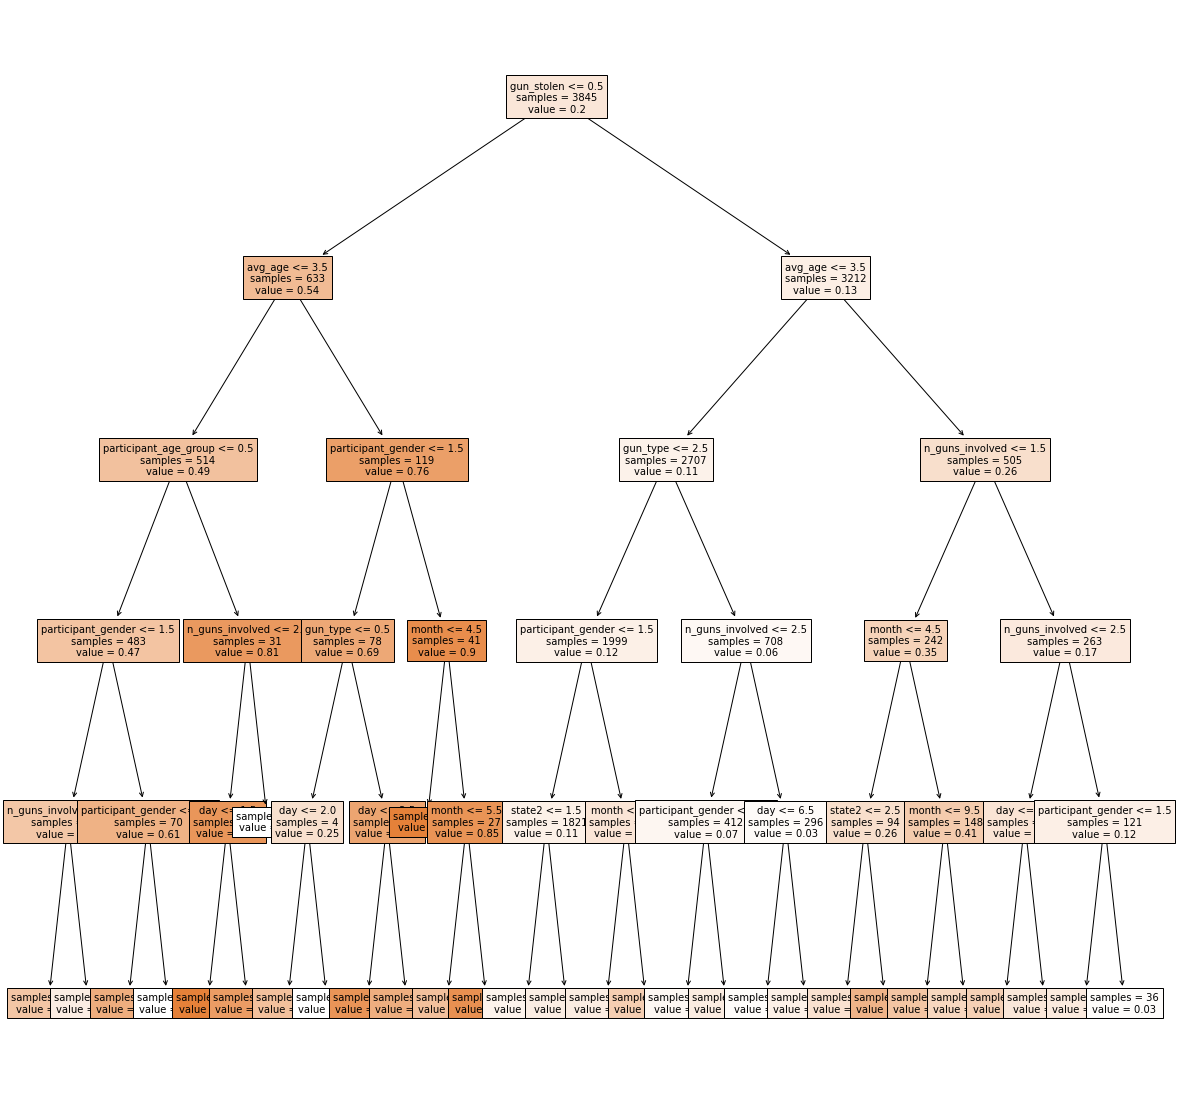

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))

print(f"Profundidad del árbol: {modelo5.get_depth()}")
print(f"Número de nodos terminales: {modelo5.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo5,
            feature_names = variables_independientes.columns,
            class_names   = 'Numero de muertos',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

In [ ]:
texto_modelo5 = export_text(
                    decision_tree = modelo5,
                    feature_names = list(variables_independientes.columns)
               )
print(texto_modelo5)

|--- gun_stolen <= 0.50
|   |--- avg_age <= 3.50
|   |   |--- participant_age_group <= 0.50
|   |   |   |--- participant_gender <= 1.50
|   |   |   |   |--- n_guns_involved <= 2.50
|   |   |   |   |   |--- value: [0.46]
|   |   |   |   |--- n_guns_involved >  2.50
|   |   |   |   |   |--- value: [0.14]
|   |   |   |--- participant_gender >  1.50
|   |   |   |   |--- participant_gender <= 2.50
|   |   |   |   |   |--- value: [0.65]
|   |   |   |   |--- participant_gender >  2.50
|   |   |   |   |   |--- value: [0.00]
|   |   |--- participant_age_group >  0.50
|   |   |   |--- n_guns_involved <= 2.00
|   |   |   |   |--- day <= 1.50
|   |   |   |   |   |--- value: [1.00]
|   |   |   |   |--- day >  1.50
|   |   |   |   |   |--- value: [0.78]
|   |   |   |--- n_guns_involved >  2.00
|   |   |   |   |--- value: [0.00]
|   |--- avg_age >  3.50
|   |   |--- participant_gender <= 1.50
|   |   |   |--- gun_type <= 0.50
|   |   |   |   |--- day <= 2.00
|   |   |   |   |   |--- value: [0.50]
|  

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': variables_independientes.columns,
                             'importancia': modelo5.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


predictor  importancia
2             gun_stolen     0.667448
7                avg_age     0.126965
4        n_guns_involved     0.050770
6     participant_gender     0.049308
0                  month     0.032881
5  participant_age_group     0.024445
3               gun_type     0.023028
1                    day     0.013837
8                 state2     0.011320

In [ ]:
predicciones = modelo5.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.35981336752560455


In [ ]:
acc_decision_test = round(modelo5.score(X_test, y_test) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_test, "%")

precisión:  17.99 %


In [ ]:
acc_decision_train = round(modelo5.score(X_train, y_train) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_train, "%")

precisión:  22.17 %


**Profundidad 3 con Ada**

In [ ]:
#se utiliza adaboost para la mejora de la prediccion con un arbol de profundidad 4
regr_1 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3), 
                          n_estimators=300, random_state=123)

In [ ]:
regr_1.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                  

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': variables_independientes.columns,
                             'importancia': regr_1.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


predictor  importancia
2             gun_stolen     0.690996
7                avg_age     0.161384
4        n_guns_involved     0.053309
6     participant_gender     0.031699
5  participant_age_group     0.028953
3               gun_type     0.019042
8                 state2     0.008597
1                    day     0.006020
0                  month     0.000000

In [ ]:
predicciones = regr_1.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.3600981625051588


In [ ]:
acc_decision_test = round(regr_1.score(X_test, y_test) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_test, "%")

precisión:  17.86 %


In [ ]:
acc_decision_train = round(regr_1.score(X_train, y_train) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_train, "%")

precisión:  19.19 %


**Profundidad 4 con Ada**

In [ ]:
#se utiliza adaboost para la mejora de la prediccion con un arbol de profundidad 4
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), 
                          n_estimators=300, random_state=123)


In [ ]:
regr_2.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=4,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                  

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': variables_independientes.columns,
                             'importancia': regr_2.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


predictor  importancia
2             gun_stolen     0.504550
7                avg_age     0.155051
3               gun_type     0.068972
6     participant_gender     0.066274
4        n_guns_involved     0.056919
0                  month     0.043493
8                 state2     0.041767
1                    day     0.039858
5  participant_age_group     0.023118

In [ ]:
predicciones = regr_2.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.37037849528414907


In [ ]:
acc_decision_test = round(regr_2.score(X_test, y_test) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_test, "%")

precisión:  13.1 %


In [ ]:
acc_decision_train = round(regr_2.score(X_train, y_train) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_train, "%")

precisión:  16.62 %


**Profundidad 5 con Ada**

In [ ]:
#se utiliza adaboost para la mejora de la prediccion con un arbol de profundidad 4
regr_3 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), 
                          n_estimators=300, random_state=123)

In [ ]:
regr_3.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=5,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                  

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': variables_independientes.columns,
                             'importancia': regr_3.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


predictor  importancia
2             gun_stolen     0.388579
7                avg_age     0.149049
0                  month     0.087494
6     participant_gender     0.082445
8                 state2     0.080759
3               gun_type     0.079300
1                    day     0.060573
4        n_guns_involved     0.047929
5  participant_age_group     0.023872

In [ ]:
predicciones = regr_3.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.3807134133463782


In [ ]:
acc_decision_test = round(regr_3.score(X_test, y_test) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_test, "%")

precisión:  8.19 %


In [ ]:
acc_decision_train = round(regr_3.score(X_train, y_train) * 100, 2) #se obtiene la precision de los datos
print("precisión: ",acc_decision_train, "%")

precisión:  16.89 %


#**SVM**


**kernel RBF**

In [ ]:
# Kernel RBF
SVM_2 = svm.SVR(kernel='rbf')
SVM_2.fit(X_train, y_train)
prediccion =SVM_2.predict(X_test)
precision_SVM2 = cross_val_score(SVM_2,X_test,y_test,cv=3)
print('Precisión Kernel RBF: ', precision_SVM2)
print( precision_SVM2.mean())

Precisión Kernel RBF:  [0.04509319 0.10791678 0.04490886]
0.06597294317085174


In [ ]:
predicciones = SVM_2.predict(X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.37661318364345064


**kernel poly**

In [ ]:
# Kernel poly
SVM_3 = svm.SVR(kernel='poly')
SVM_3.fit(X_train, y_train)
prediccion =SVM_3.predict(X_test)
precision_SVM3 = cross_val_score(SVM_3,X_test,y_test,cv=3)
print('Precisión Kernel poly: ', precision_SVM3)
print( precision_SVM3.mean())

Precisión Kernel poly:  [-0.02157699  0.09473608  0.06044903]
0.04453603973790843


In [ ]:
predicciones = SVM_3.predict(X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.3703009067956148


**kernel linear**

In [ ]:
# Kernel liner
SVM_4 = svm.SVR(kernel='linear')
SVM_4.fit(X_train, y_train)
prediccion =SVM_4.predict(X_test)
precision_SVM4 = cross_val_score(SVM_4,X_test,y_test,cv=3)
print('Precisión Kernel linear: ', precision_SVM4)
print( precision_SVM4.mean())

Precisión Kernel linear:  [-0.04269014 -0.02692352 -0.00048633]
-0.02336666093319188


In [ ]:
predicciones = SVM_4.predict(X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.4016119147948386


#**Redes bayesianas**

In [ ]:
X_trains, X_tests, y_trains, y_tests = train_test_split(variables_independientes, variables_objetivo['heridos'], test_size = 0.3)

In [ ]:
clf_bayes = GaussianNB() #Definición del algoritmo
clf_bayes.fit(X_trains, y_trains) #Entrenamiento del algoritmo
Y_predicts = clf_bayes.predict(X_tests) #Predicción del target en base a los datos de prueba

In [ ]:
rmse = mean_squared_error(y_tests,Y_predicts)
print("El error (rmse) de test es: ", rmse)

El error (rmse) de test es:  0.1787941787941788


In [ ]:
#Calculo de la precisión del modelo
from sklearn.metrics import precision_score
from sklearn import metrics
precision_bayes = precision_score(y_tests, Y_predicts, average = 'micro')
print('Precisión del Modelo: ', precision_bayes)

Precisión del Modelo:  0.8212058212058212


In [ ]:
# Matriz de Confusión para Clasificador Bayessiano
matriz_bayes = metrics.confusion_matrix(y_tests, Y_predicts)
print('Matriz de Confusión Clasificador Bayessiano: ')
print(matriz_bayes)

Matriz de Confusión Clasificador Bayessiano: 
[[1043  109]
 [ 149  142]]


Text(69.0, 0.5, 'Truth')

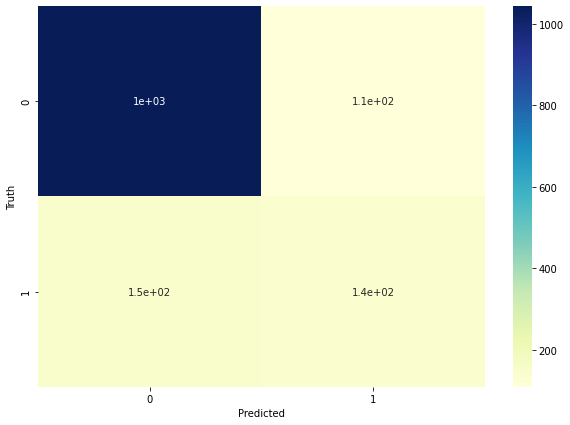

In [ ]:
import seaborn as sns

%matplotlib inline
plt.figure(figsize=(10,7))
sns.heatmap(matriz_bayes, annot=True, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Truth')

#**Validacion cruzada**

In [ ]:
## Funciones
def precision(cf,i,t):
    if(t == 0): txt = '- all'
    else: txt = ' - test'
    p_noheridos = round(float(cf[0][0])*100/cf[0].sum(),2)
    p_heridos = round(float(cf[1][1])*100/cf[1].sum(),2)
    p_modelo = round(float(cf[0][0]+cf[1][1])*100/cf.sum(),2)
    return [p_noheridos, p_heridos, p_modelo]

def valida_global(model,k):
  col_train = ['month', 'day', 'state2', 'avg_age', 'participant_gender', 'n_guns_involved', 'gun_type', 'gun_stolen']
  p_noheridos_all = [];p_noheridos_test = [];p_heridos_all = [];p_heridos_test = [];p_all = [];p_test = [];
  for i in range(k):
      tmp_train, tmp_test = train_test_split(datos2, test_size = 0.5)
      tmp_train_target = tmp_train[['heridos']].values
      tmp_test_target = tmp_test[['heridos']].values
      tmp_train = tmp_train[col_train].values
      tmp_test = tmp_test[col_train].values
      modelo = model.fit(tmp_train, tmp_train_target.ravel())
      tmp_train_pred = modelo.predict(tmp_train)
      cf_train = confusion_matrix(tmp_train_target, tmp_train_pred)
      [p_noheridos, p_heridos, p_modelo] = precision(cf_train,i,0)
      p_noheridos_all.append(p_noheridos)
      p_heridos_all.append(p_heridos)
      p_all.append(p_modelo)
      tmp_test_pred = modelo.predict(tmp_test)
      cf_test = confusion_matrix(tmp_test_target, tmp_test_pred)
      [p_noheridos, p_heridos, p_modelo] = precision(cf_test,i,1)
      p_noheridos_test.append(p_noheridos)
      p_heridos_test.append(p_heridos)
      p_test.append(p_modelo)
    # Precision Global
  print("Acierto para No heridos:")
  print("All - ",round(np.array(p_noheridos_all).mean(),2))
  print("Test - ",round(np.array(p_noheridos_test).mean(),2))
  print("Acierto para Heridos:")
  print("All - ",round(np.array(p_heridos_all).mean(),2))
  print("Test - ",round(np.array(p_heridos_test).mean(),2))
  print("Acierto para Modelo:")
  print("All - ",round(np.array(p_all).mean(),2))
  print("Test - ",round(np.array(p_test).mean(),2))

*Validación Cruzada con Arbol de Decision con Indice de Gini*

In [ ]:
valida_global(arbolGini,50)

Acierto para No heridos:
All -  99.91
Test -  84.05
Acierto para Heridos:
All -  86.51
Test -  35.01
Acierto para Modelo:
All -  97.26
Test -  74.42


*Validación Cruzada con Random Forest*

In [ ]:
valida_global(randomForest,10)

Acierto para No heridos:
All -  99.36
Test -  91.7
Acierto para Heridos:
All -  89.2
Test -  31.2
Acierto para Modelo:
All -  97.37
Test -  79.75


*Validación Cruzada con Redes*

In [ ]:
valida_global(clf_bayes,20)

Acierto para No heridos:
All -  90.2
Test -  89.99
Acierto para Heridos:
All -  45.75
Test -  45.37
Acierto para Modelo:
All -  81.43
Test -  81.21


*Validación Cruzada con Arbol de Decision de Entropia Cruzada*

In [ ]:
valida_global(arbolEntropy,20)

Acierto para No heridos:
All -  99.89
Test -  84.36
Acierto para Heridos:
All -  86.84
Test -  34.27
Acierto para Modelo:
All -  97.34
Test -  74.38


*Validación Cruzada con Adaboost*

In [ ]:
valida_global(adaBoost,20)

Acierto para No heridos:
All -  95.32
Test -  95.24
Acierto para Heridos:
All -  32.86
Test -  30.76
Acierto para Modelo:
All -  82.99
Test -  82.56


*Validación Cruzada con Bayesiano Ingenuo*

In [ ]:
valida_global(gNaiveBayes,20)

Acierto para No heridos:
All -  90.27
Test -  90.03
Acierto para Heridos:
All -  46.16
Test -  44.72
Acierto para Modelo:
All -  81.63
Test -  81.06
